In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pandas as pd
import statsmodels.api as sm

from bayesian import load_and_transform_company_data

dir = "data/"
df = load_and_transform_company_data(dir+"data4columbia_credit.csv",min_max_data=False)
df

company       date           data         t
0       ef1bcca724f3 2016-01-01  266648.924500  0.000000
1       ef1bcca724f3 2016-01-02  330109.961300  0.000399
2       ef1bcca724f3 2016-01-03  248299.827200  0.000798
3       ef1bcca724f3 2016-01-04  146428.339600  0.001198
4       ef1bcca724f3 2016-01-05  146854.815500  0.001597
...              ...        ...            ...       ...
116654  e2415cb7f63d 2022-11-05    1149.371612  0.998004
116655  e2415cb7f63d 2022-11-06     890.458833  0.998403
116656  e2415cb7f63d 2022-11-07    1233.454763  0.998802
116657  e2415cb7f63d 2022-11-08    2478.464933  0.999202
116658  e2415cb7f63d 2022-11-09    2027.376001  0.999601

[116659 rows x 4 columns]

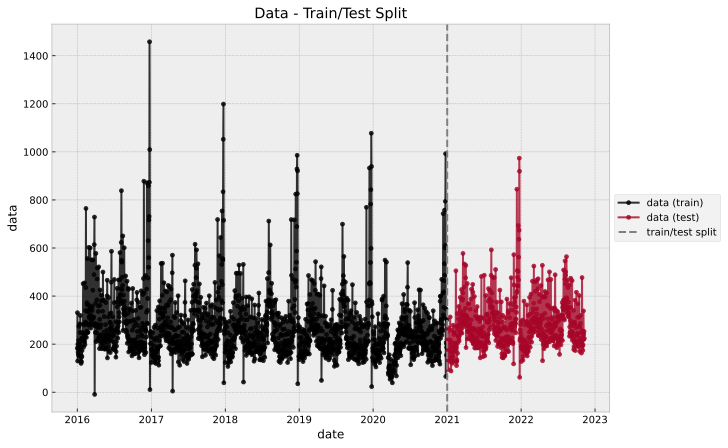

In [3]:
import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,7)
from bayesian import run_decompose

train_test_date = datetime.datetime(2021,1,1)
#change '1' to another company to test different data
df_train, df_test = run_decompose(df, 1, train_test_date)

#Plot train test split
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="data",
    data=df_train,
    marker="o",
    color="black",
    alpha=0.8,
    markersize=4,
    markeredgecolor="black",
    label="data (train)",
    ax=ax,
)
sns.lineplot(
    x="date",
    y="data",
    data=df_test,
    marker="o",
    color="C1",
    alpha=0.8,
    markersize=4,
    markeredgecolor="C1",
    label="data (test)",
    ax=ax,
)
ax.axvline(x=train_test_date, color="gray", linestyle="--", label="train/test split")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Data - Train/Test Split");

/tmp/ipykernel_594899/2036909924.py:2: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift
Sampling: [lag_coefs, likelihood, α, β, β_fourier_yr, σ]


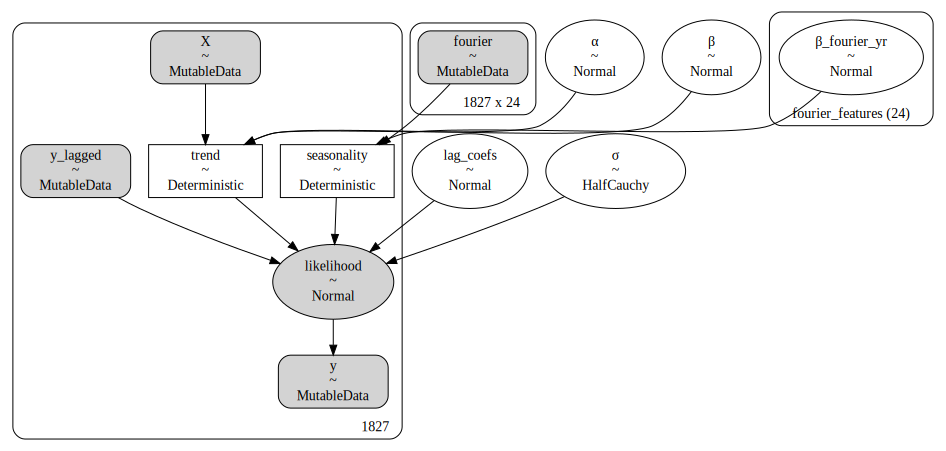

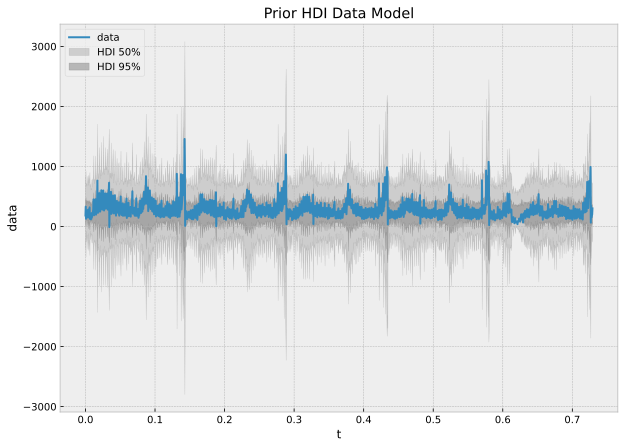

In [29]:
import numpy as np
from scipy.ndimage.interpolation import shift
from bayesian import BayesianModel


m =BayesianModel(model_type='unpooled',train_data=df_train,test_data=df_test)
m.setup_model()
m.sample_prior()

pm.model_to_graphviz(m.model)

In [30]:
data = m.sample_posterior()
az.summary(data=data)



Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ, lag_coefs, β_fourier_yr]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 168 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd   
α                160.665  6.254  150.695  173.098      0.302    0.214  \
β                 -0.542  0.999   -2.370    1.247      0.031    0.046   
lag_coefs          0.400  0.021    0.360    0.437      0.001    0.001   
β_fourier_yr[0]   -4.323  3.000  -10.072    1.117      0.093    0.084   
β_fourier_yr[1]    7.815  2.980    2.353   13.078      0.092    0.065   
...                  ...    ...      ...      ...        ...      ...   
trend[1822]      160.271  6.251  149.824  172.152      0.304    0.215   
trend[1823]      160.271  6.251  149.823  172.152      0.304    0.215   
trend[1824]      160.270  6.251  149.821  172.152      0.304    0.215   
trend[1825]      160.270  6.251  149.819  172.151      0.304    0.215   
trend[1826]      160.270  6.251  149.817  172.151      0.304    0.215   

                 ess_bulk  ess_tail  r_hat  
α                   425.0     375.0   1.00  
β                  1041.0     275.0   1.01  
lag_coefs           424.0     360.0   1.00  
β_fourier_yr[0]    1041.0     280.0   1.01  
β_fourier_yr[1]    1041.0     368.0   1.05  
...                   ...       ...    ...  
trend[1822]         424.0     375.0   1.00  
trend[1823]         424.0     375.0   1.00  
trend[1824]         424.0     375.0   1.00  
trend[1825]         424.0     375.0   1.00  
trend[1826]         424.0     375.0   1.00  

[3682 rows x 9 columns]

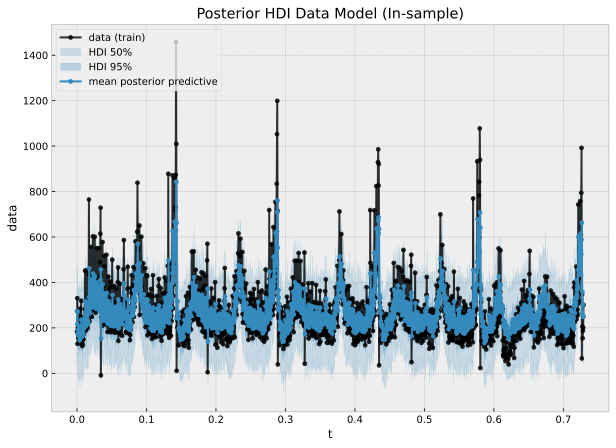

In [31]:
m.plot_trace()
m.plot_posterior_insample_fit()

Sampling: [likelihood]


7184.30900334846

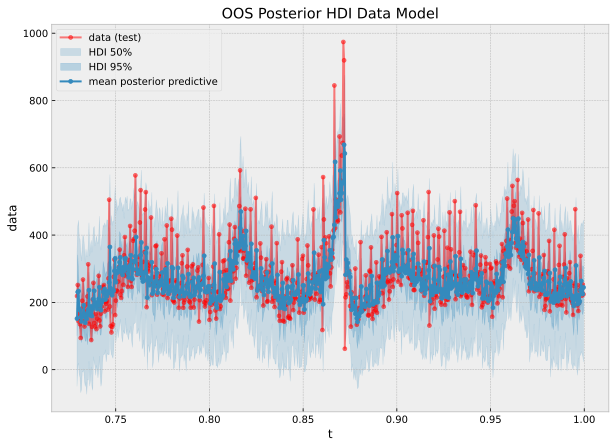

In [32]:
m.sample_test_data()
res_true, res_pred = m.plot_test_result()

from sklearn.metrics import mean_squared_error
mean_squared_error(res_true,res_pred)